In [15]:
from SocialNetwork.social_network_environment import *
from SocialNetwork.cascade import *
from Advertising.enviroment.bid import *
from Advertising.enviroment.VCG import *
from Advertising.learners.TSLearner import *
from tqdm.autonotebook import tqdm
import scipy.stats
import scipy.special as sc

In [16]:
class UCB_Learner():
    def __init__(self, n_arms, arms, n_categories, ad_id):
        self. n_arms = n_arms
        self.n_categories = n_categories
        self.ad_id = ad_id
        self.reward_per_arm = np.zeros((n_categories, n_arms))
        self.empirical_mean = np.ones((n_categories, n_arms))
        self.confidence = np.ones((n_categories, n_arms))*np.inf
        self.count = np.zeros((n_categories, n_arms))
        self.collected_rewards = []
        self.t = 0
        self.c = 5.0  # exploration factor

    def pull_arm(self):
        ucb = self.empirical_mean+self.confidence
        pulled_arm = np.argmax(ucb, axis=-1)

        bids = [Bid(pulled_arm[i], self.ad_id) for i in range(5)]
        return bids

    def update(self, pulled_arm, reward):
        self.t += 1

        self.collected_rewards.append(reward)
        for i in range(self.n_categories):

            self.reward_per_arm[i][pulled_arm[i].bid] += reward[i]
            self.count[i][pulled_arm[i].bid] += 1

            self.empirical_mean[i][pulled_arm[i].bid
                                   ] = self.reward_per_arm[i][pulled_arm[i].bid]/self.count[i][pulled_arm[i].bid]
            # exploration factor
            self.confidence[i][pulled_arm[i].bid] = self.c*np.sqrt(
                2*np.log(self.t)/(self.count[i][pulled_arm[i].bid]-1))
        for i in range(self.n_categories):
            self.empirical_mean[i][self.count[i] == 0] = np.inf
            self.confidence[i][self.count[i] == 0] = np.inf


In [17]:
def reward_control_allocation(best_allocation, ad_id, reward):
    temp=[]
    for i in range(5):
        control = False
        for j in range(len(best_allocation[i])):
            if (best_allocation[i][j].ad_id == ad_id):
                control = True
                break
        if control:
            # temp.append(reward)
            temp.append(reward)
        else:
            temp.append(0)
    return temp        


In [18]:
def test(n_test=1000,learner=None, vcg=None):
    rewards=[]
    for i in tqdm(range(n_test)):
        bids_adversaries = []
        for i in range(0, 5):
            bid_categoria = np.array([])
            for j in range(0, 10):  # numero di avversari
                bid = Bid(bid=random.randint(1, 4), id=j+3)
                bid_categoria = np.append(bid_categoria, bid)
            bids_adversaries.append(bid_categoria)

    # add the bid of the learner to our campain
    #pulled_arm_ts = ts_learner.pull_arm()
        pulled_arm= learner.pull_arm()
        for i in range(5):
        #bids_adversaries[i][0] = pulled_arm_ts[i]
          bids_adversaries[i][1] = pulled_arm[i]



        best_allocation = vcg.all_best_allocations(list_camp_bids=bids_adversaries, social_network=social_network)
    # ACTIVATE THE CASCADE OF OUR SOCIAL NETWORK AND COMPUTE THE REWARDS
        reward = activate_cascade(social_network=social_network,
                              ad_allocation_list=best_allocation, slot_prominence=lambdas)
    
    # with this part of code i set that if the learner is present in the allocation list then get the normal allocation
    # reward, if it's not present and it bids 0 then the reward is 0.
    #
    #temp_ts = reward_control_allocation(best_allocation, 1, reward)
        temp= reward_control_allocation(best_allocation,1, reward)
 
    # updating of the learners
    #ts_learner.update(pulled_arm_ts, temp_ts)
        learner.update(pulled_arm, temp)
    
        rewards.append(reward)
    plt.figure(0)
    plt.plot(np.array(rewards), 'r')
    plt.show()


100%|██████████| 1000/1000 [00:04<00:00, 249.95it/s]


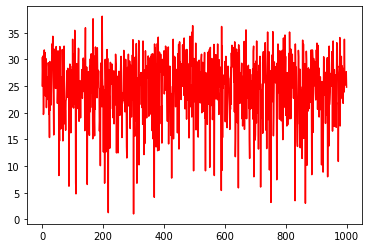

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-16-255226fcc145>:34: RuntimeWarning: invalid value encountered in double_scalars
  2*np.log(self.t)/(self.count[i][pulled_arm[i].bid]-1))
<ipython-input-16-255226fcc145>:34: RuntimeWarning: divide by zero encountered in double_scalars
  2*np.log(self.t)/(self.count[i][pulled_arm[i].bid]-1))
100%|██████████| 1000/1000 [00:04<00:00, 206.19it/s]


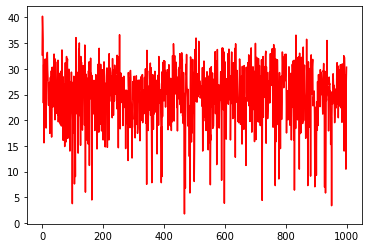

In [19]:
#setting of the environment for the test
prev_reward = 0
social_network = social_network_environment()
social_network.init_from_json(
    json_path_network='Config/network.json', json_path_features='Config/features.json')
lambdas = [0.8, 0.5, .44, 0.40, 0.35, 0.20]
arms = [0, 1, 2, 3, 4]
vcg = VCG()

random.seed(1234)


ts_learner = TS_Learner(n_arms=len(arms), arms=arms, n_categories=5, ad_id=1)
ucb_learner = UCB_Learner(n_arms=len(arms), arms=arms, n_categories=5, ad_id=1)
test(1000, ts_learner, vcg)
test(1000, ucb_learner,vcg)

In [20]:
print(ucb_learner.empirical_mean)
print(ucb_learner.confidence)
print(ucb_learner.count)

[[ 0.          0.         16.028      23.87811912 25.10529319]
 [ 0.          5.64923077 17.2064     22.49849246 25.06782609]
 [ 0.          7.71428571 18.00982456 23.56945455 25.1397546 ]
 [ 0.          0.         15.29777778 22.65428571 25.29329815]
 [ 0.          6.48571429  7.97142857 23.58853147 25.10023392]]
[[23.54820045 27.19411597 11.82118489  4.1680888   2.96171449]
 [23.54820045 21.38475299 10.5210552   5.26375603  2.74201481]
 [23.54820045 20.25135744  9.9338924   4.47458812  2.91185893]
 [23.54820045 27.8776307  12.47437139  5.30409191  2.7018767 ]
 [23.54820045 20.52841224 19.85622163  4.40342937  2.84406928]]
[[  2.   8.  40. 319. 631.]
 [  2.  13.  50. 199. 736.]
 [  2.  14.  57. 275. 652.]
 [  2.   8.  36. 196. 758.]
 [  2.  14.  14. 286. 684.]]
